In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display

import os
os.chdir('../')

from lateral_connections import LateralModel, VggModel, CustomImageDataset

In [1]:
model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2'])

#model = LateralModel(vgg_model=vm, distance=2, num_output_repetitions=4)
model = LateralModel(vgg_model=vm, distance=2, num_output_repetitions=4, alpha=0.01)

def torch_transform(img):
    return img.reshape((1,) + img.shape).float()

ds = CustomImageDataset('images/geometric_dataset/annotations.csv', image_transform=torch_transform)


# TODO: Histogram over Time (Input? Output? Kernel?...)
# see https://matplotlib.org/stable/gallery/statistics/hist.html


In [2]:
RUN_WANDB = False

if RUN_WANDB:
    import wandb
    wandb.init(project="MT_LateralConnections", entity="lehl")

pbar = tqdm(range(16))

mink = []
maxk = []
meank = []

for i in pbar:
    img_id = np.random.randint(len(ds))
    img, label = ds[img_id]
    pbar.set_description(f"Processing #{img_id} ({ds.labels[label]})")
    
    model.forward(img)
    
    """
    datak = torch.sum(model.K, dim=(-2,-1)).cpu()
    mink.append(datak.numpy().min())
    maxk.append(datak.numpy().max())
    meank.append(datak.numpy().mean())
    
    display.clear_output(wait=True)
    plt.clf()
    
    plt.plot(mink, label='Min')
    plt.plot(meank, label='Mean')
    plt.plot(maxk, label='Max')
    plt.grid(True)
    plt.xlabel('Iteration')
    display.display(plt.gcf())
    """
    
    if RUN_WANDB:
        # Log to WandB
        wandb_dict = dict()
        logging_config = {
            'input': model.A,
            'kernel': model.K,
            'lateral_activity': model.L,
            'output': model.O
        }

        for k in logging_config.keys():
            data = logging_config[k].cpu().detach().numpy()

            wandb_dict[k] = {
                'min': np.min(data),
                'max': np.max(data),
                'mean': np.mean(data)
            }

            for p in range(0,110,10):
                wandb_dict[k][f"{p}pctl"] = np.percentile(data, p)
    
        #print(wandb_dict)        
        wandb.log(wandb_dict)

  0%|          | 0/16 [00:00<?, ?it/s]

# Try Kernel Convolution Ideas

Image at:  images/geometric_dataset/cube/cube_00376_X154_Y116_Z072.png
---
---
1.0


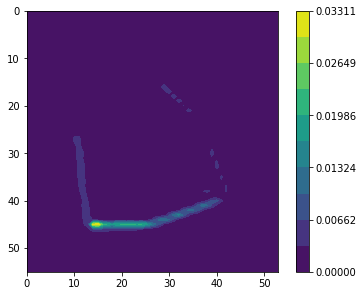

tensor([2.7807, 0.2223, 0.1319, 3.0284, 1.6879, 0.5134, 0.4000, 1.0194, 0.6449,
        0.5801, 0.1964, 0.1390, 0.1654, 1.1172, 0.2382, 0.2421, 0.8631, 0.0915,
        1.2291, 0.6062, 1.6715, 0.1265, 3.0502, 0.2607, 0.1474, 1.1681, 0.9142,
        0.3206, 0.2039, 0.5655, 3.3164, 2.2310, 3.5000, 0.1405, 1.4733, 1.5264,
        2.2361, 0.2951, 0.4664, 0.0757, 0.3717, 0.5346, 0.3819, 3.9786, 0.2399,
        0.3887, 0.7979, 0.3364, 0.6331, 0.0987, 0.6481, 0.7382, 0.1186, 0.4465,
        0.2951, 1.0722, 3.7923, 0.3404, 2.9450, 0.5128, 0.1817, 0.3110, 0.3652,
        1.4291, 1.4899, 3.1849, 0.2231, 2.0861, 0.3038, 0.1082, 5.4954, 0.0996,
        4.7436, 1.2485, 0.5808, 0.1531, 0.0598, 0.1672, 3.5023, 0.7443, 0.9834,
        0.1379, 2.5262, 1.0242, 3.8440, 0.6603, 1.4458, 0.5890, 0.8738, 4.1063,
        1.3425, 0.4097, 0.3166, 0.7936, 0.1919, 0.2652, 0.3820, 0.1163, 1.0118,
        0.4419, 0.0927, 0.3262, 1.2720, 2.3240, 3.5349, 0.4373, 1.5568, 4.7558,
        0.2717, 0.9910, 0.2062, 2.8176, 

'\nplt.imshow(m[0,...].cpu().detach().numpy())\nplt.show()\nplt.imshow(softmax_on_fm(m[0,...]).cpu())\nplt.show()\nplt.imshow(minmax_on_fm(softmax_on_fm(m[0,...])).cpu())\nplt.show()\n'

In [140]:
def print_tensor(t: torch.Tensor):
    t_cpu = t.cpu().detach().numpy()
    #print(f"{t_cpu.shape}\t\t{t_cpu.min():2.3f}\t\t{t_cpu.mean():2.3f}\t\t{t_cpu.max():2.3f}")
    
img_index = 1400
img,_ = ds[img_index]
print("Image at: ", ds.df.iloc[img_index].file_path)
with torch.no_grad():
    A = model.vgg_model.net(img.to(model.gpu_device))[0,...]
    print_tensor(A)

    A[...,:model.prd,:] = torch.flip(A[...,model.prd:2*model.prd,:], dims=(-2,))         # top edge
    A[...,-model.prd:,:] = torch.flip(A[...,-2*model.prd:-model.prd,:], dims=(-2,))      # bottom edge
    A[...,:,:model.prd] = torch.flip(A[...,:,model.prd:2*model.prd], dims=(-1,))         # left edge
    A[...,:,-model.prd:] = torch.flip(A[...,:,-2*model.prd:-model.prd], dims=(-1,))      # right edge
    print_tensor(A)

    A = torch.broadcast_to(A, (model.n,) + A.shape).reshape((model.n * A.shape[0],) + A.shape[1:]).to(model.gpu_device)
    print_tensor(A)
    
    noise = torch.normal(torch.zeros(A.shape), torch.ones(A.shape)).to(model.gpu_device)
    A = torch.clip(A + model.eta * noise, min=0.0)
    print_tensor(A)
    
    a = 0
    x = 2
    y = 0

    print('---')

    xoff_f = - model.d + x
    yoff_f = - model.d + y
    influencing_feature_maps = A[:, max(0, xoff_f):A.shape[-2]+min(xoff_f, 0), max(0, yoff_f):A.shape[-1]+min(0, yoff_f)]
    print_tensor(influencing_feature_maps)
    
    # The activation to be influenced
    #
    xoff_i = model.d - x
    yoff_i = model.d - y
    influenced_feature_map = A[a, max(0, xoff_i):A.shape[-2]+min(xoff_i, 0), max(0, yoff_i):A.shape[-1]+min(0, yoff_i)]
    print_tensor(influenced_feature_map)

    #self.K[:, a, x, y] += self.alpha * torch.sum(influencing_feature_maps * influenced_feature_map, dim=(1,2))

    print('---')
    m = influencing_feature_maps * influenced_feature_map
    print_tensor(m)
    s = torch.sum(m, dim=(1,2))
    print_tensor(s)

""" 
plt.imshow(influenced_feature_map.cpu())
plt.show()
plt.imshow(influencing_feature_maps[0,...].cpu())
plt.show()
"""

def plot_with_bar(data):    
    fig, ax = plt.subplots(constrained_layout=True)
    
    figure_data = data.cpu().numpy()
    levels = np.linspace(np.min(figure_data), np.max(figure_data), 11)

    if np.unique(levels).shape == levels.shape:
        cs = ax.contourf(figure_data, levels)
        fig.colorbar(cs, ax=ax)
    ax.set_aspect('equal','box')
    ax.invert_yaxis()
    print(np.sum(figure_data))
    plt.show()

def softmax(x):

    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

from lateral_connections.torch_utils import *

plot_with_bar(torch.sum(softmax_on_fm(m),dim=0) / 512)
print(torch.sum(m,dim=(1,2)) / 512)

"""
plot_with_bar(m[0,...])
plot_with_bar(softmax_on_fm(m[0,...]))
plot_with_bar(minmax_on_fm(softmax_on_fm(m[0,...])))
"""
"""
plt.imshow(m[0,...].cpu().detach().numpy())
plt.show()
plt.imshow(softmax_on_fm(m[0,...]).cpu())
plt.show()
plt.imshow(minmax_on_fm(softmax_on_fm(m[0,...])).cpu())
plt.show()
"""


# Logarithmize?

torch.Size([128, 56, 56])


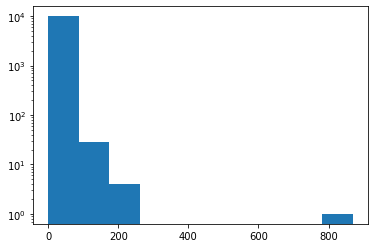

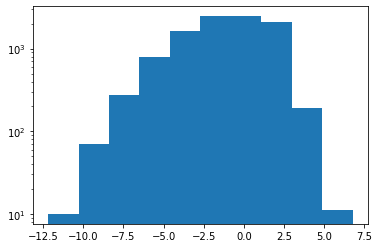

(3.046080340513392, -1.2152784006791126)

In [66]:
"""
img_index = 1400

img,_ = ds[img_index]
print("Image at: ", ds.df.iloc[img_index].file_path)

model.forward(img, update=False)
"""

vgg_A = model.vgg_model.net(img.to(model.gpu_device))[0,...]
print(vgg_A.shape)


A = vgg_A.cpu().detach().numpy()

np.set_printoptions(precision=3, suppress=True)

# Get 1-100th percentiles from all values in A
Av = np.percentile(np.unique(A.ravel()), np.arange(1, 101, 1))

# Get cross-products of each combination
K = Av[:, np.newaxis] * np.tile(Av, 100).reshape((100,100))

# Show histogram
plt.hist(K.ravel())
plt.yscale('log')
plt.show()

plt.hist(np.log(K.ravel()))
plt.yscale('log')
plt.show()

(np.mean(K), np.mean(np.log(K)))

# Save & Load Model

In [3]:
#model.save_model('models/lateral_models/20220128_2048it_nosoftmax.h5')

Saved model to models/lateral_models/20220128_2048it_nosoftmax.h5 successfully.


In [25]:
model.load_model('models/lateral_models/20220128_2048it_nosoftmax.h5')

Loaded model from models/lateral_models/20220128_2048it_nosoftmax.h5 successfully.	(2048 train iterations detected.)
		Config used:	d: 2, k: 5, h: 64, mu: 0.005, alpha: 0.8


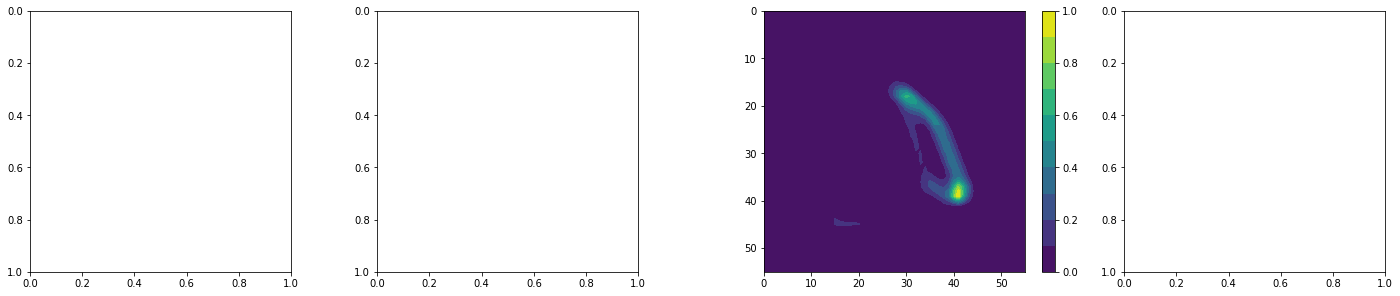

In [10]:
from lateral_connections.torch_utils import *

data_initial = torch.clip(F.conv2d(model.padded_A.unsqueeze(0), model.K.transpose_(0, 1), padding=0).squeeze() / model.A.shape[0], min=0.0, max=1.0)

fm_sum = torch.sum(data_initial, dim=(-2,-1), keepdim=True)
# Avoid division by zero
fm_sum[fm_sum == 0] = 1.0
softmaxed = data_initial / fm_sum
data_softmax = softmaxed

data_minmaxed = torch.clone(model.L)


fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(20,4))

# Before Softmax Plot =================================================
figure_data = data_initial[0,...].cpu().numpy()
levels = np.linspace(np.min(figure_data), np.max(figure_data), 11)

if np.unique(levels).shape == levels.shape:
    cs = axs[0].contourf(figure_data, levels)
    fig.colorbar(cs, ax=axs[0])
axs[0].set_aspect('equal','box')
axs[0].invert_yaxis()

# After Softmax Plot ==================================================
figure_data = data_softmax[0,...].cpu().numpy()
levels = np.linspace(np.min(figure_data), np.max(figure_data), 11)

if np.unique(levels).shape == levels.shape:
    cs = axs[1].contourf(figure_data, levels)
    fig.colorbar(cs, ax=axs[1])
axs[1].set_aspect('equal','box')
axs[1].invert_yaxis()

# MinMax Scaled =======================================================
figure_data = data_minmaxed[0,...].cpu().numpy()
#figure_data[figure_data < 0.8] = 0
levels = np.linspace(np.min(figure_data), np.max(figure_data), 11)

if np.unique(levels).shape == levels.shape:
    cs = axs[2].contourf(figure_data, levels)
    fig.colorbar(cs, ax=axs[2])
axs[2].set_aspect('equal','box')
axs[2].invert_yaxis()

# Activation FM Scaled ================================================
#figure_data = model.A[0,...].cpu().numpy()
figure_data = softmax_minmax_scaled(data_initial)[0,...].cpu().numpy()

#figure_data[figure_data < 0.8] = 0
levels = np.linspace(np.min(figure_data), np.max(figure_data), 11)

if np.unique(levels).shape == levels.shape:
    cs = axs[3].contourf(figure_data, levels)
    fig.colorbar(cs, ax=axs[3])
axs[3].set_aspect('equal','box')
axs[3].invert_yaxis()


None

Image at:  images/geometric_dataset/cube/cube_00376_X154_Y116_Z072.png


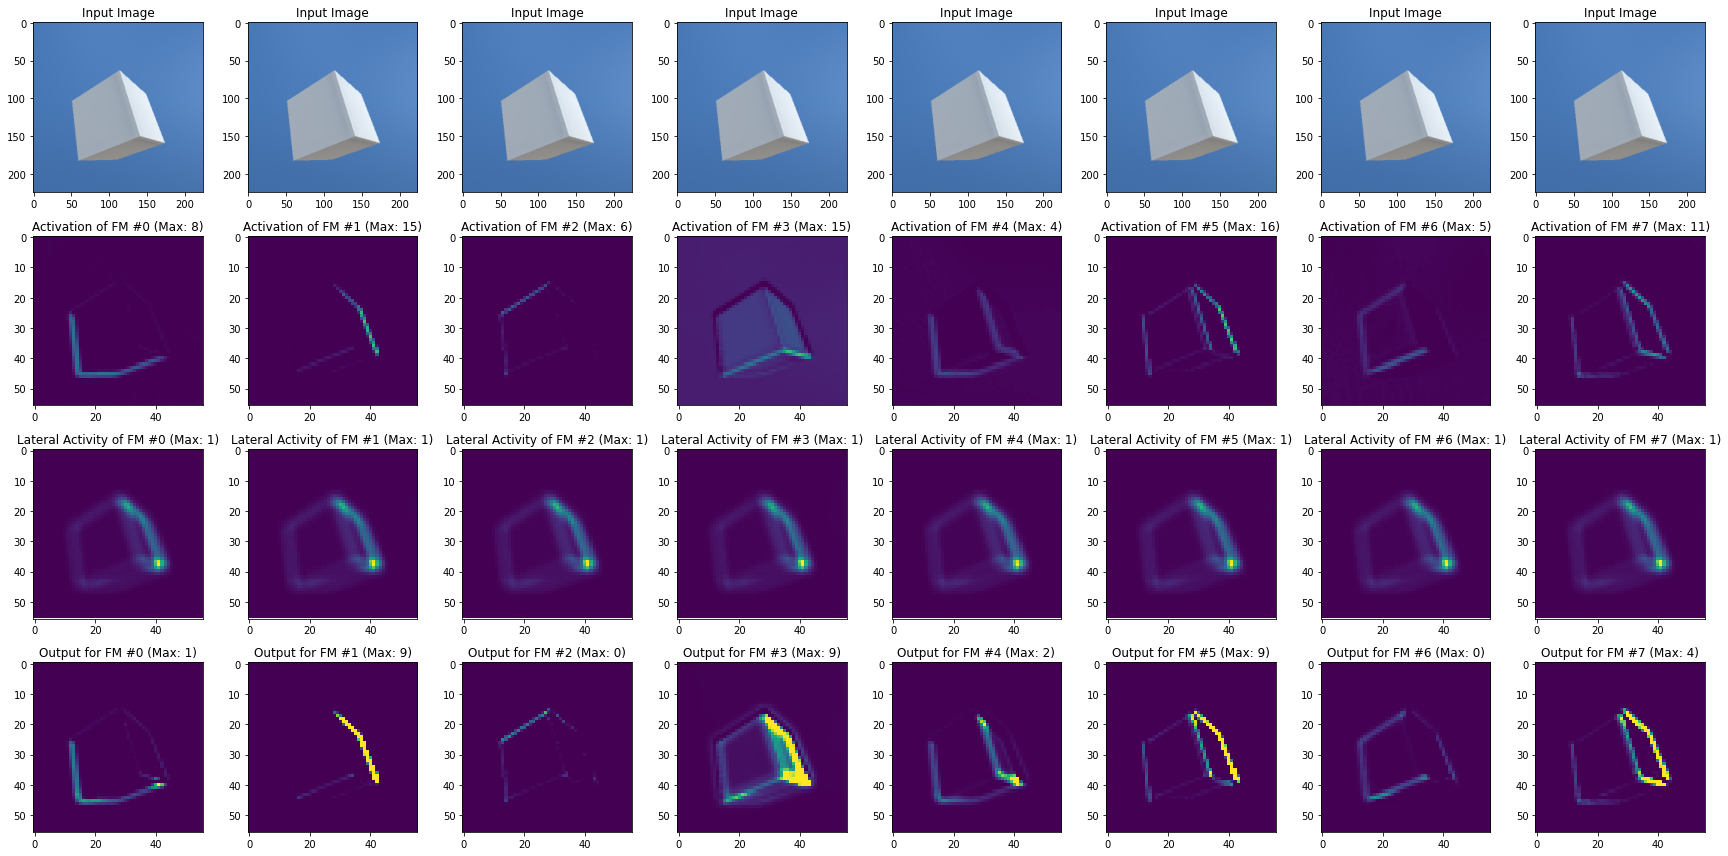

In [4]:
#img_index = np.random.randint(len(ds))
img_index = 1400

img,_ = ds[img_index]
print("Image at: ", ds.df.iloc[img_index].file_path)

model.forward(img, update=False)

num_fms = 8
plot_scale = 3

fig, axs = plt.subplots(4,num_fms,figsize=(num_fms*plot_scale, 4*plot_scale))

for f in range(num_fms):
    data0 = torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).cpu().numpy().astype(int)
    axs[0, f].imshow(data0, vmin=0, vmax=1)
    axs[0, f].set_title(f"Input Image")
    
    data1 = model.A[-1, f,:,:].cpu().detach().numpy()
    axs[1,f].imshow(data1, vmin=0, vmax=np.max(model.A.cpu().numpy()))
    axs[1,f].set_title(f"Activation of FM #{f} (Max: {int(np.max(data1))})")
    
    data2 = model.L[f,:,:].cpu().detach().numpy()
    #axs[2,f].imshow(data2, vmin=0, vmax=1)
    axs[2,f].imshow(data2, vmin=0, vmax=np.max(model.L.cpu().numpy()))
    axs[2,f].set_title(f"Lateral Activity of FM #{f} (Max: {int(np.max(data2))})")
    
    #axs[3,f].imshow(data1*data2, vmin=0, vmax=1)
    data3 = model.O[-1,f,:,:].cpu().detach().numpy()
    axs[3,f].imshow(data3, vmin=0, vmax=1)
    #axs[3,f].imshow(data3, vmin=0, vmax=np.max(model.O.cpu().numpy()))
    axs[3,f].set_title(f"Output for FM #{f} (Max: {int(np.max(data3))})")

plt.tight_layout()

In [13]:
model.O[:,0,0,0]

tensor([7.3457e-07, 7.6723e-07, 9.1131e-07, 9.2321e-07, 1.0697e-06, 1.0622e-06,
        1.2112e-06, 1.1855e-06, 1.3359e-06, 1.2942e-06, 0.0000e+00],
       device='cuda:0')

In [9]:
torch.isnan(model.K).any()

tensor(False, device='cuda:0')

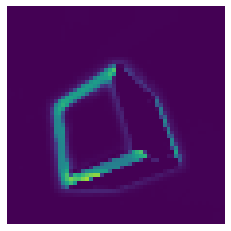

In [34]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

def minmax_scale(x):
    return (x - x.min()) / (x.max() - x.min())

for f in [0, 1, 3, 4, 6]:
    data = model.L[f, :, :].cpu().detach().numpy()

    data = softmax(data)
    data = minmax_scale(data)

    plt.imshow(data, vmin=0, vmax=1)
    plt.axis('off')
    plt.savefig('lateral_activation_' +str(f)+'.png', bbox_inches='tight', pad_inches=0)
    
    data = model.A[f,:,:].cpu().detach().numpy() * data

    plt.imshow(data, vmin=0, vmax=1)
    plt.axis('off')
    plt.savefig('lateral_output_' +str(f)+'.png', bbox_inches='tight', pad_inches=0)

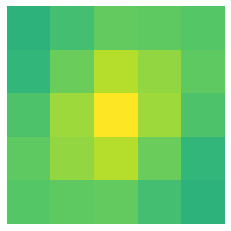

In [35]:
for f in [0, 1, 3, 4, 6]:
    for f2 in [0, 1, 3, 4, 6]:
        plt.imshow(model.K[f2, f,:8,:8].cpu(),vmin=0)
        plt.axis('off')
        plt.savefig('kernel' + str(f2) + '-' + str(f) + '.png', bbox_inches='tight', pad_inches=0)

(512, 512, 5, 5)


  0%|          | 0/6 [00:00<?, ?it/s]

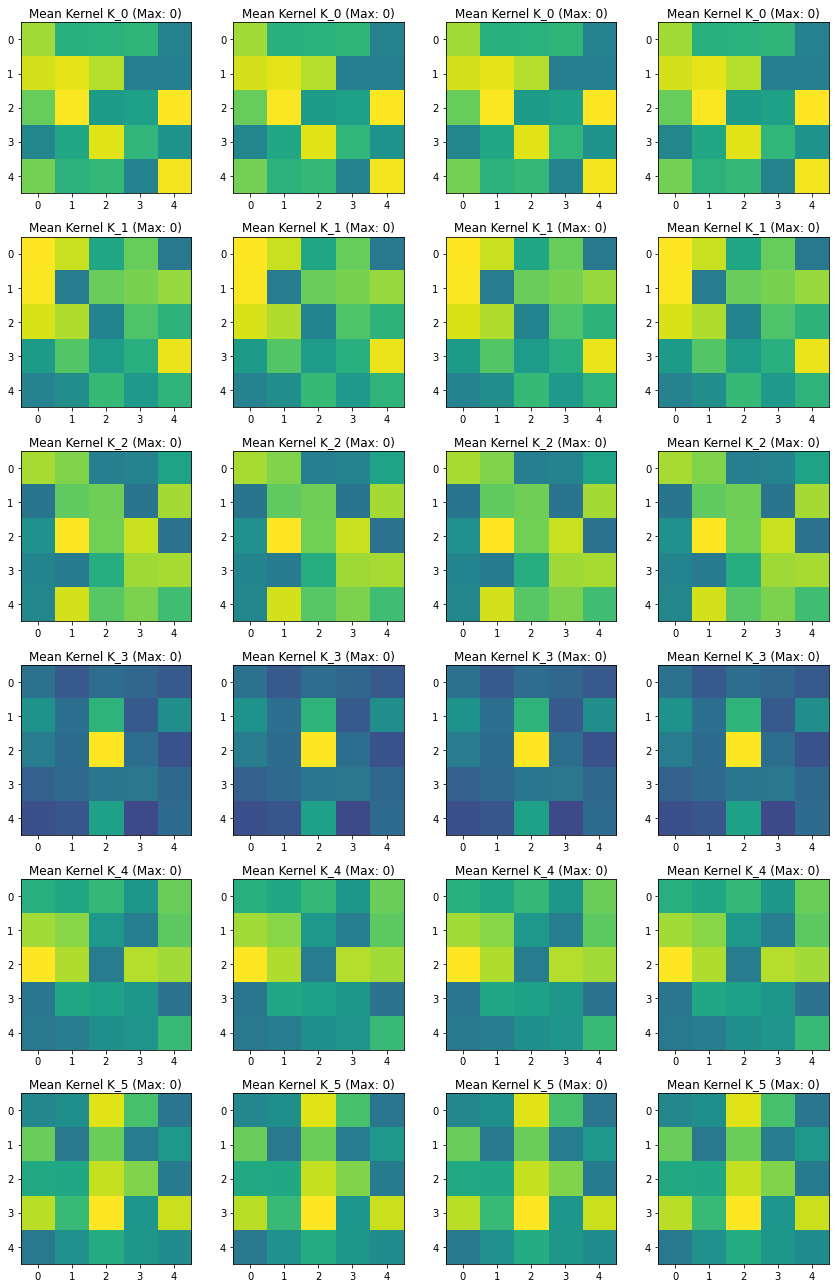

In [5]:
data = model.K.cpu().detach().numpy()
print(data.shape)

max_kernels = np.max(data, axis=(2,3))[..., np.newaxis, np.newaxis]
max_kernels[max_kernels==0] = 1.0
scaled_kernels = np.sum(data / max_kernels, axis=1)

num_kernels_to_plot = 6
plot_scale = 3
fig, axs = plt.subplots(num_kernels_to_plot, model.n, figsize=(plot_scale*model.n, plot_scale*num_kernels_to_plot))

for i in tqdm(range(num_kernels_to_plot)):
    for j in range(model.n):
        kernel_index = i+(model.A.shape[0]//model.n)*j
        
        data = model.K.cpu().detach().numpy()[kernel_index, i, :, :]
        #data = scaled_kernels[kernel_index,:,:]
        #axs[i,j].imshow(data, vmin=0, vmax=model.K.shape[0])
        axs[i,j].imshow(data, vmin=0, vmax=np.max(data))
        axs[i,j].set_title(f"Mean Kernel K_{kernel_index} (Max: {int(np.max(data))})")
plt.tight_layout()

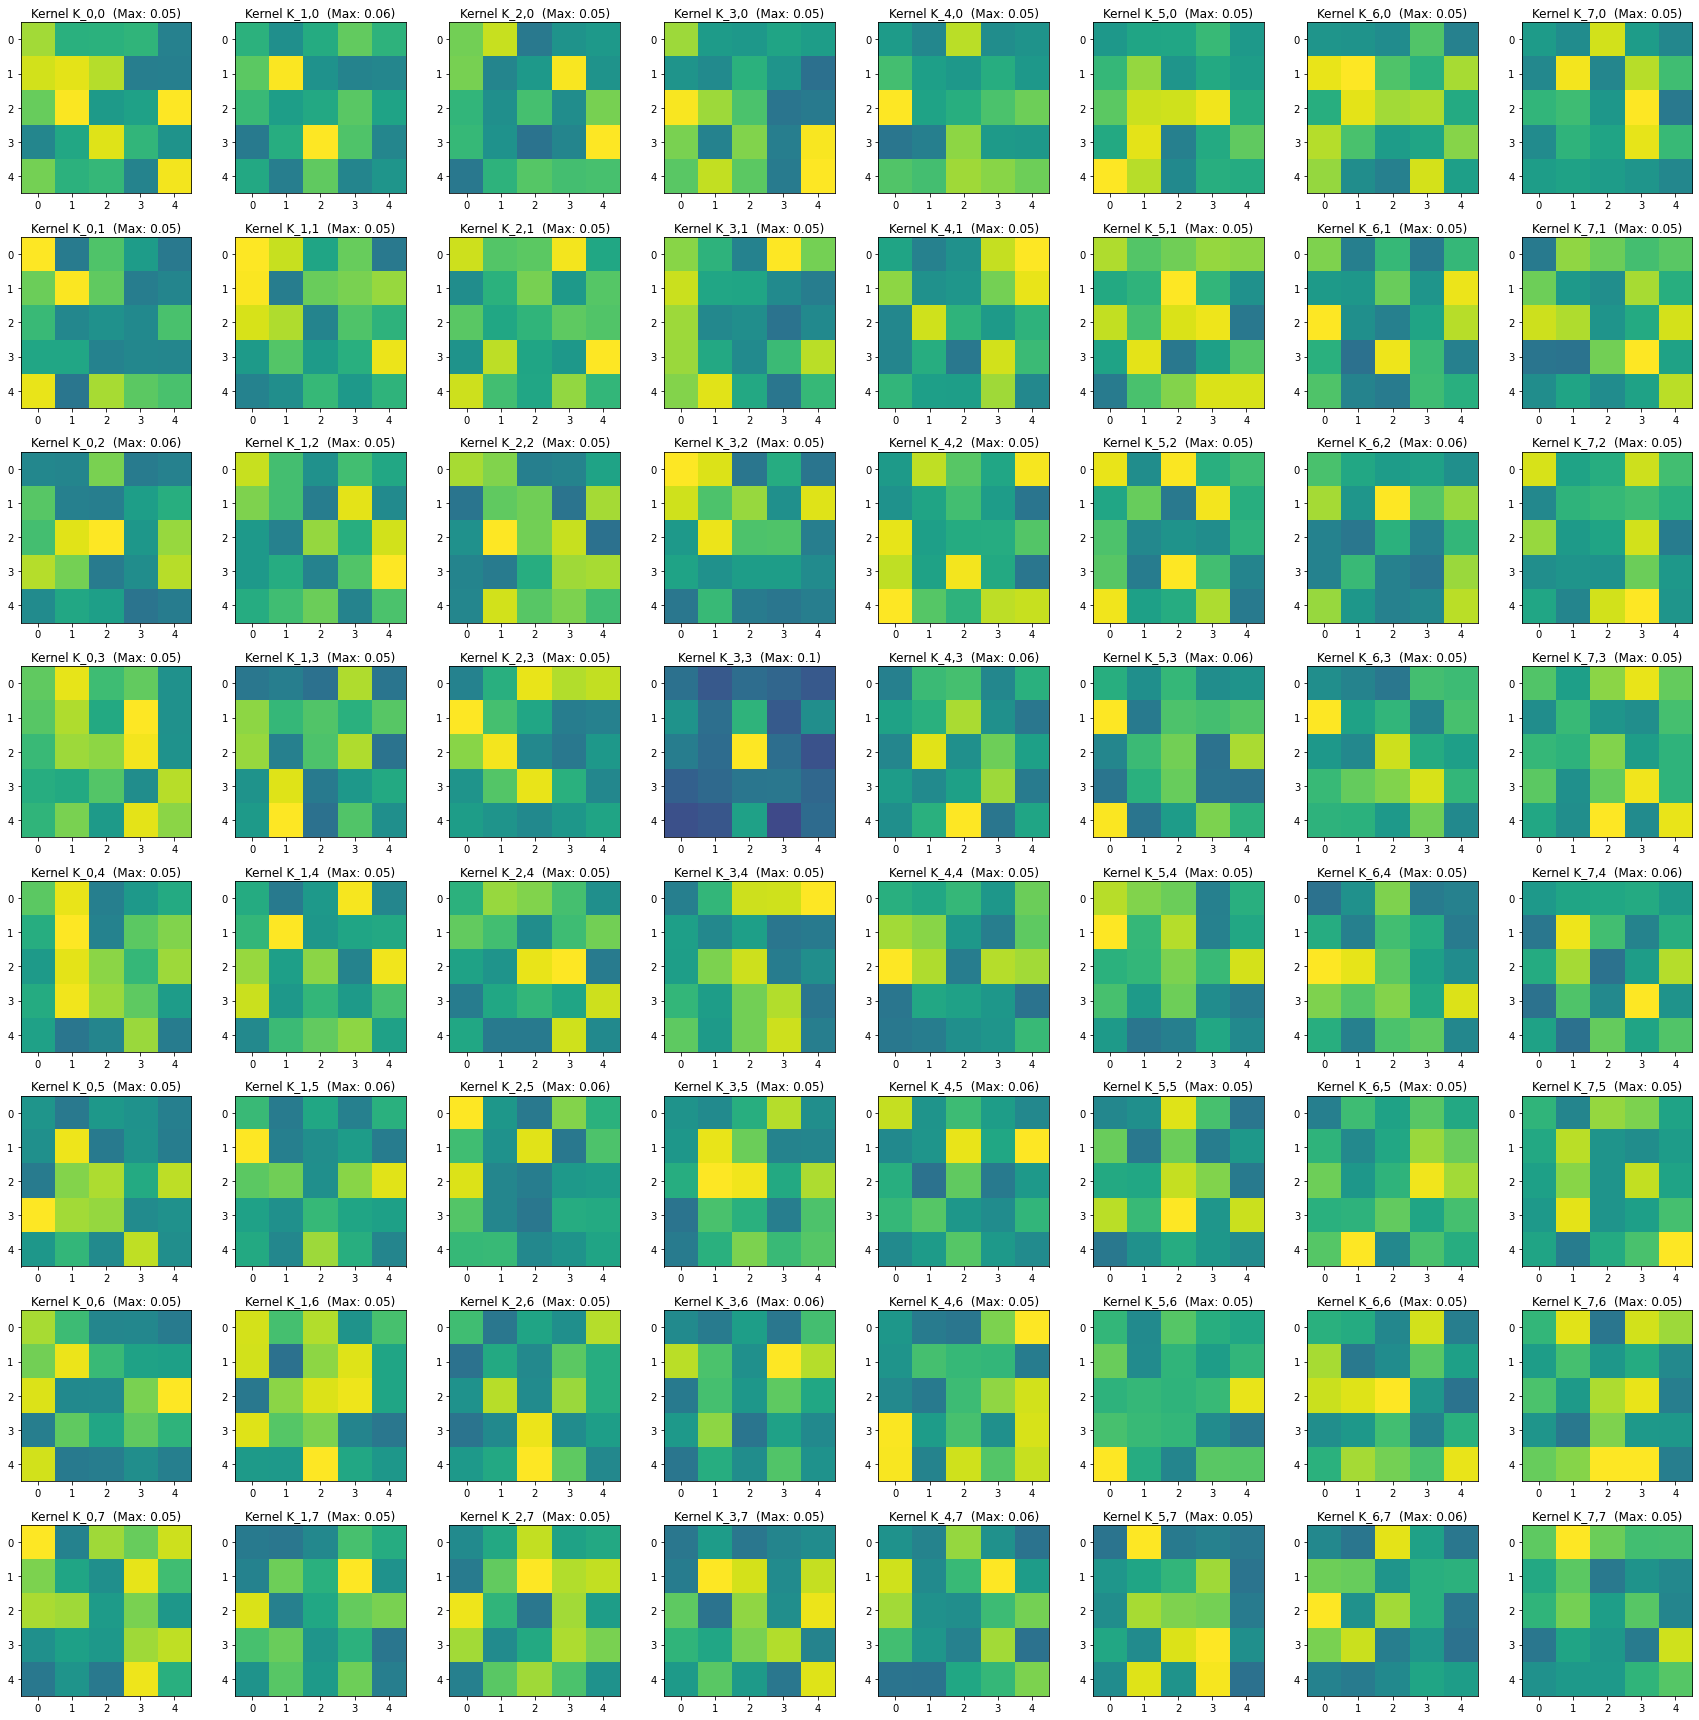

In [6]:
num_input_feature_maps = 8
num_output_feature_maps = 8
plot_scale = 3

fig, axs = plt.subplots(num_output_feature_maps, num_input_feature_maps, figsize=(plot_scale*num_output_feature_maps,plot_scale*num_input_feature_maps))

for i in range(num_output_feature_maps):
    for j in range(num_input_feature_maps):
        data = model.K[i, j, :, :].cpu().detach().numpy()
        #axs[i,j].imshow(data, vmin=0, vmax=0.1)
        axs[i,j].imshow(data, vmin=0, vmax=np.max(data))
        axs[i,j].set_title(f"Kernel K_{j},{i}  (Max: {round(float(np.max(data)), 2)})")
plt.tight_layout()

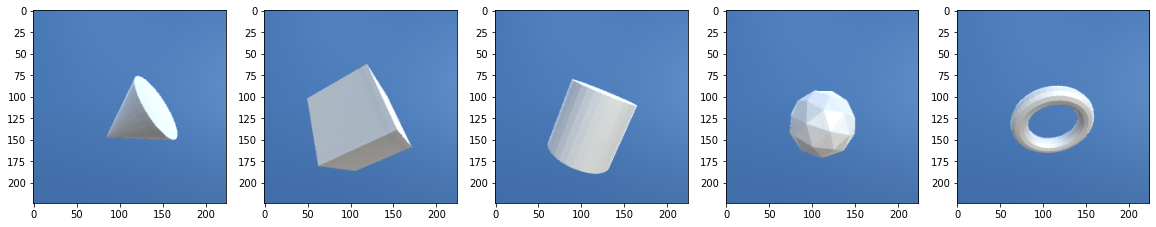

In [22]:
def plottable_image(img):
    return torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).numpy().astype(int)

j = 500

num_objects = 5
fig, axs = plt.subplots(1, num_objects, figsize=(4*num_objects, 4))

for i in range(num_objects):
    idx = i*1024 + j
    
    img, _ = ds[idx]
    axs[i].imshow(plottable_image(img))
    
    

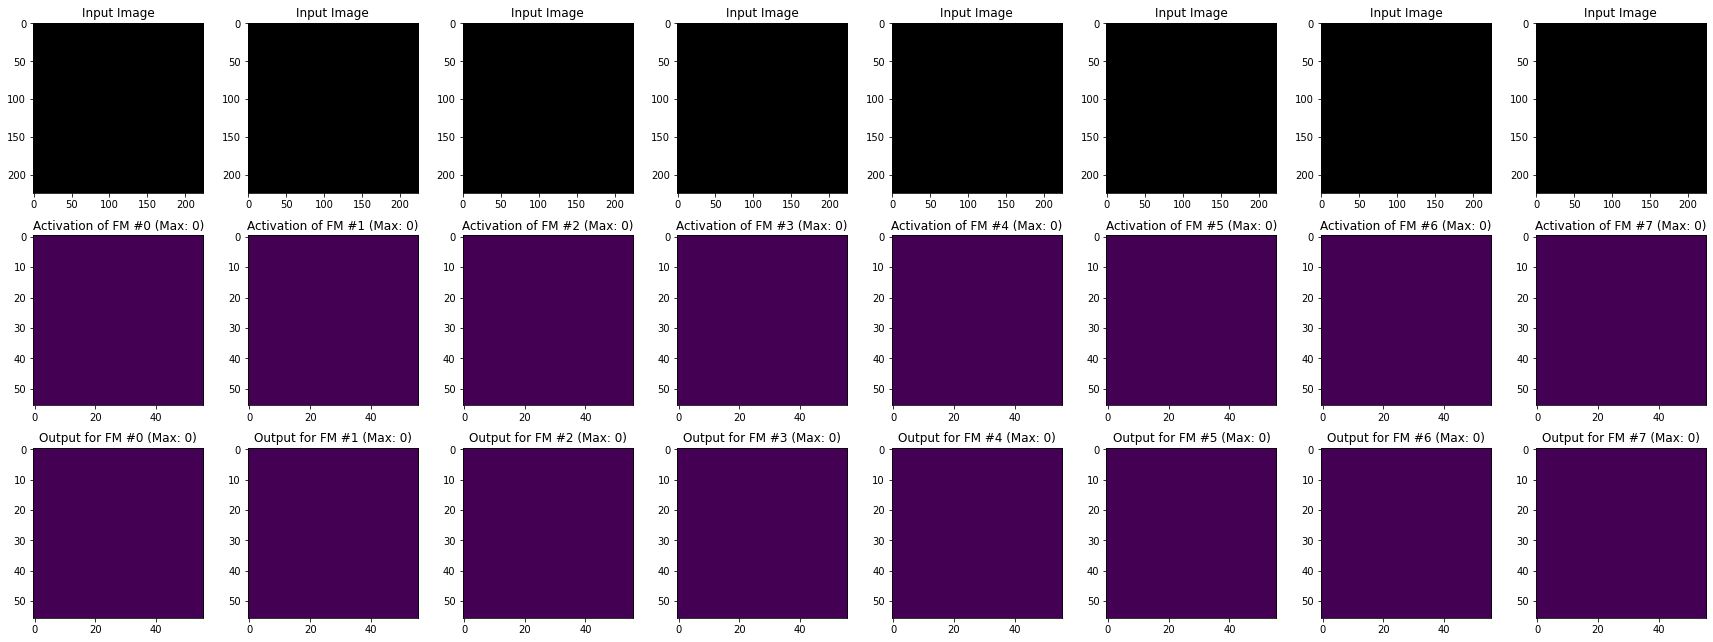

In [11]:
img = torch.Tensor(np.zeros(shape=img.shape)).to(model.gpu_device)
model.forward(img, update=False)

num_fms = 8
plot_scale = 3
fig, axs = plt.subplots(3,num_fms,figsize=(num_fms*plot_scale,3*plot_scale))

for f in range(num_fms):
    data = torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).cpu().numpy().astype(int)
    axs[0, f].imshow(data, vmin=0, vmax=1)
    axs[0, f].set_title(f"Input Image")
    
    data = model.A[f,:,:].cpu().detach().numpy()
    axs[1,f].imshow(data)
    axs[1,f].set_title(f"Activation of FM #{f} (Max: {int(np.max(data))})")
    
    data = model.O[f,:,:].cpu().detach().numpy()
    axs[2,f].imshow(data)
    axs[2,f].set_title(f"Output for FM #{f} (Max: {int(np.max(data))})")

plt.tight_layout()

/tmp/ipykernel_1731/2356851631.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  t4 = torch.nn.functional.log_softmax(t)


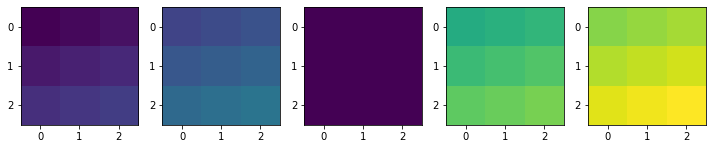

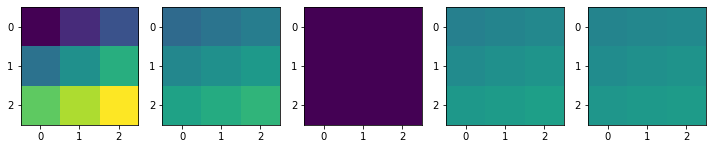

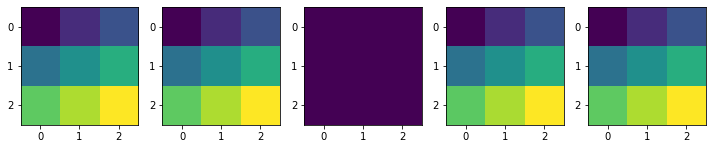

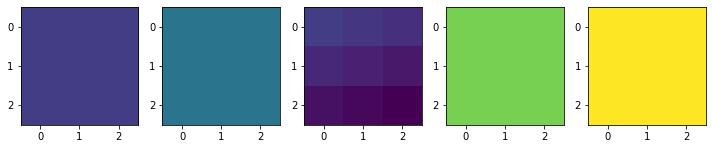

In [10]:
# Test to check how the softmax and minmax scaling have to be applied, such that only the final
# 2 dimensions (feature map / image) are affected, but not across multiple image/feature maps
#
def plot_tensor(t, title=None, vmin=0):
    fig, axs = plt.subplots(1, t.shape[-3], figsize=(t.shape[-3]*2,3))
    for i in range(t.shape[-3]):
        axs[i].imshow(t[0,i,...], vmin=vmin, vmax=t.max())
    plt.tight_layout()
    #     if title:
    #         plt.suptitle(title)
    #         fig.subplots_adjust(top=1)
    plt.show()
    plt.close()

# Applies first the softmax, then minmax scaling to the given tensor, keeping
# the dimensions in tact.
#
def softmax_minmax_scaled(t: torch.Tensor):
    t1 = softmax_on_fm(t)
    return minmax_on_fm(t2)

# Applies the Softmax (2D) to the given Tensor
#
# Assume the given tensor has any shape, where the final two dimensions represent some
# kind of image or feature map. Dimensions are kept identical.
#
def softmax_on_fm(t: torch.Tensor):
    fm_sum = torch.sum(t, dim=(-2,-1), keepdim=True)

    # Avoid division by zero
    fm_sum[fm_sum == 0] = 1.0

    return t / fm_sum

# Applies MinMax Scaling (2D) to the given Tensor
#
# Assume the given tensor has any shape, where the final two dimensions represent some
# kind of image or feature map. Dimensions are kept identical.
#
def minmax_on_fm(t: torch.Tensor):
    t_min = torch.min(torch.min(t, dim=-2, keepdim=True).values, dim=-1, keepdim=True).values
    t_max = torch.max(torch.max(t, dim=-2, keepdim=True).values, dim=-1, keepdim=True).values
    
    t_diff = (t_max - t_min)

    # Avoid division by zero
    t_diff[t_diff == 0] = 1.0
    
    return (t - t_min) / t_diff

t = torch.arange(5*3*3).float().reshape([1,5,3,3])
t[0,2,...] = 0

t2 = softmax_on_fm(t)
t3 = minmax_on_fm(t2)
t4 = torch.nn.functional.log_softmax(t)

plot_tensor(t, title='Initial Data')
plot_tensor(t2, title='Softmax')
plot_tensor(t3, title='Softmax + MinMax Scaled')
plot_tensor(t4, title='Log Softmax', vmin=t4.min())


torch.Size([256, 56, 56])
torch.Size([256, 60, 60])
225


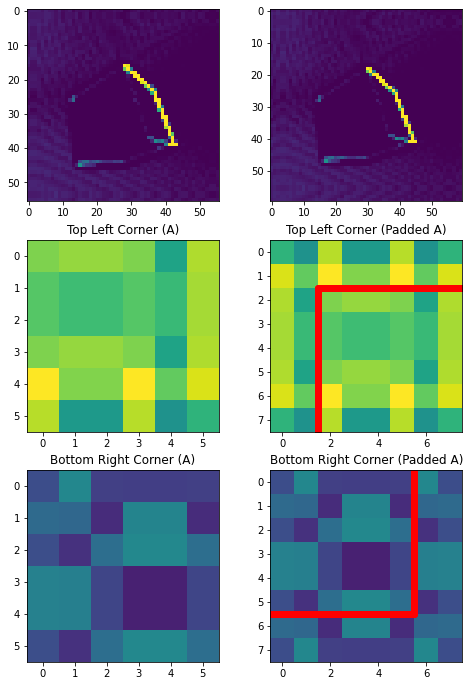

In [18]:
# Checking properties of the symmetric padding
print(model.A.shape)
print(model.padded_A.shape)

fm_i=225
print(fm_i)

fig, axs = plt.subplots(3,2, figsize=(8,12))
axs[0,0].imshow(model.A[fm_i,:,:].cpu(),vmin=0,vmax=1)
axs[0,1].imshow(model.padded_A[fm_i,:,:].cpu(),vmin=0,vmax=1)
#--------------------------------------------------------------------------
# Top Left Corner
axs[1,0].imshow(model.A[fm_i,:6,:6].cpu(), vmin=0, vmax=0.1)
axs[1,1].imshow(model.padded_A[fm_i,:8,:8].cpu(), vmin=0, vmax=0.1)
axs[1,0].set_title('Top Left Corner (A)')
axs[1,1].set_title('Top Left Corner (Padded A)')
x = np.linspace(1.5,7.5,100)
y = np.ones(shape=x.shape) * 1.5
axs[1,1].scatter(x,y,color='r',linewidth=1)
axs[1,1].scatter(y,x,color='r',linewidth=1)
#--------------------------------------------------------------------------
# Bottom Right Corner
axs[2,0].imshow(model.A[fm_i,-6:,-6:].cpu(), vmin=0, vmax=0.1)
axs[2,1].imshow(model.padded_A[fm_i,-8:,-8:].cpu(), vmin=0, vmax=0.1)
axs[2,0].set_title('Bottom Right Corner (A)')
axs[2,1].set_title('Bottom Right Corner (Padded A)')
x = np.linspace(-0.5,5.5,100)
y = np.ones(shape=x.shape) * 5.5
axs[2,1].scatter(x,y,color='r',linewidth=1)
axs[2,1].scatter(y,x,color='r',linewidth=1)

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
---
tensor(True, device='cuda:0')


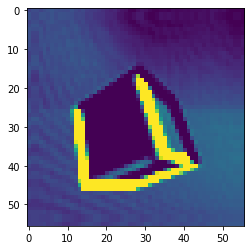

In [75]:
# Testing, in which dimensions the symmetric padding needs to be applied and how

A3 = torch.clone(model.A)

A3[...,:2,:] = torch.flip(A3[...,2:4,:], dims=(-2,))
A3[...,-2:,:] = torch.flip(A3[...,-4:-2,:], dims=(-2,))
A3[...,:,:2] = torch.flip(A3[...,:,2:4], dims=(-1,))
A3[...,:,-2:] = torch.flip(A3[...,:,-4:-2], dims=(-1,))

print((A2[:,:2,:] == A3[:,:2,:]).all())
print((A2[:,-2:,:] == A3[:,-2:,:]).all())
print((A2[:,:,:2] == A3[:,:,:2]).all())
print((A2[:,:,-2:] == A3[:,:,-2:]).all())

plt.imshow(A3.cpu().detach().numpy()[4,:,:])
print('---')
print((A3 == A2).all())

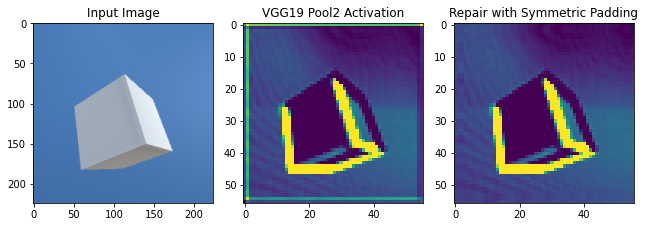

In [80]:
num_kernels_to_plot = 3
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

axs[1].imshow(model.A.cpu()[4,:,:])
axs[1].set_title(f"VGG19 Pool2 Activation")

axs[2].imshow(A3.cpu()[4,:,:])
axs[2].set_title(f"Repair with Symmetric Padding")

plt.tight_layout()

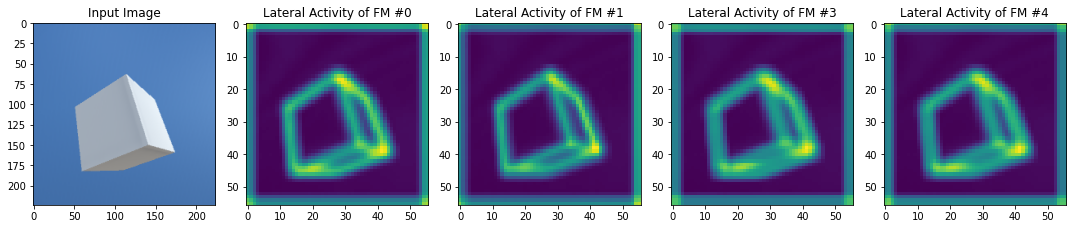

In [27]:
num_kernels_to_plot = 5
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

for i, ix in enumerate([0, 1, 3, 4]):
        data = model.L.cpu().detach().numpy()[ix,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i+1].imshow(data, vmax=np.max(data))
        axs[i+1].set_title(f"Lateral Activity of FM #{ix}")
plt.tight_layout()

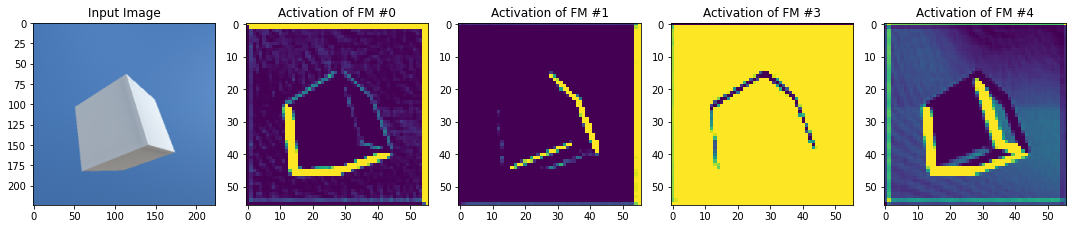

In [25]:
num_kernels_to_plot = 5
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

for i, ix in enumerate([0, 1, 3, 4]):
        data = model.A.cpu().detach().numpy()[ix,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i+1].imshow(data, vmax=np.max(data))
        axs[i+1].set_title(f"Activation of FM #{ix}")
plt.tight_layout()

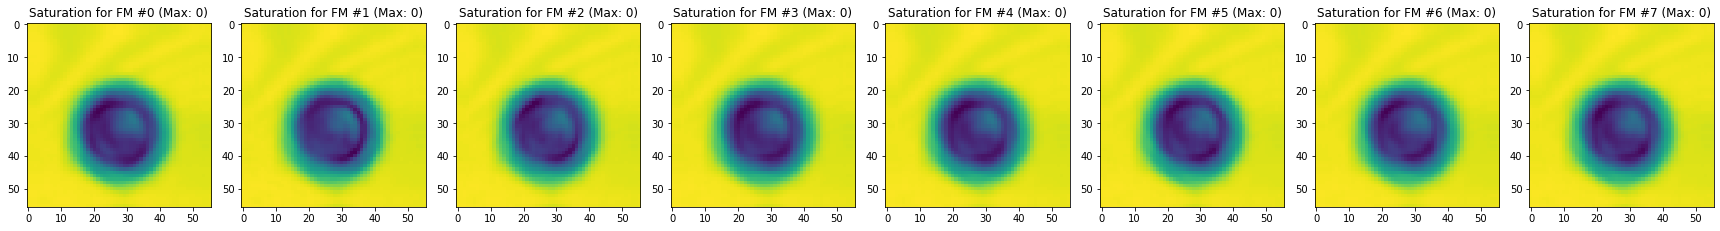

In [19]:
num_kernels_to_plot = 8
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

for i in range(num_kernels_to_plot):
        data = model.S.cpu().detach().numpy()[i,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i].imshow(data, vmax=np.max(data))
        axs[i].set_title(f"Saturation for FM #{i} (Max: {int(np.max(data))})")
plt.tight_layout()

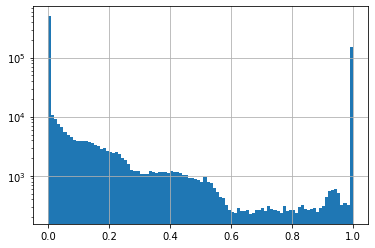

In [6]:
"""
vals, bins = np.histogram(model.A.cpu().detach().numpy(), bins=100)

print(vals)
print(bins)
"""
data = model.A.cpu().detach().numpy().reshape(-1)
plt.hist(data, bins=100)
plt.yscale('log')
plt.grid()
plt.show()



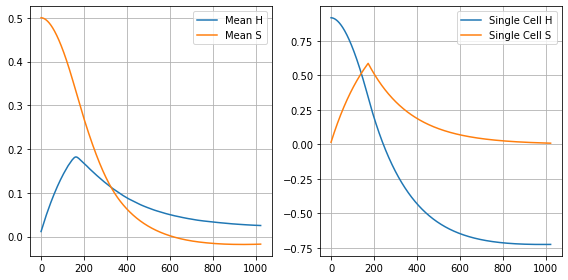

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(mean_h, label='Mean H')
axs[0].plot(mean_s, label='Mean S')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(last_h, label='Single Cell H')
axs[1].plot(last_s, label='Single Cell S')
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

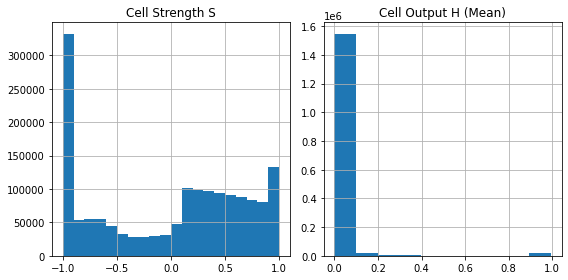

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(model.S.cpu().detach().numpy().reshape(np.prod(model.S.shape)), bins=20)
#axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].set_title('Cell Strength S')
axs[1].hist(model.H.cpu().detach().numpy().reshape(np.prod(model.H.shape)), bins=10)
#axs[1].set_yscale('log')
axs[1].grid(True)
axs[1].set_title('Cell Output H (Mean)')
plt.tight_layout()

In [52]:
model.G_d.shape

torch.Size([128, 56, 56])

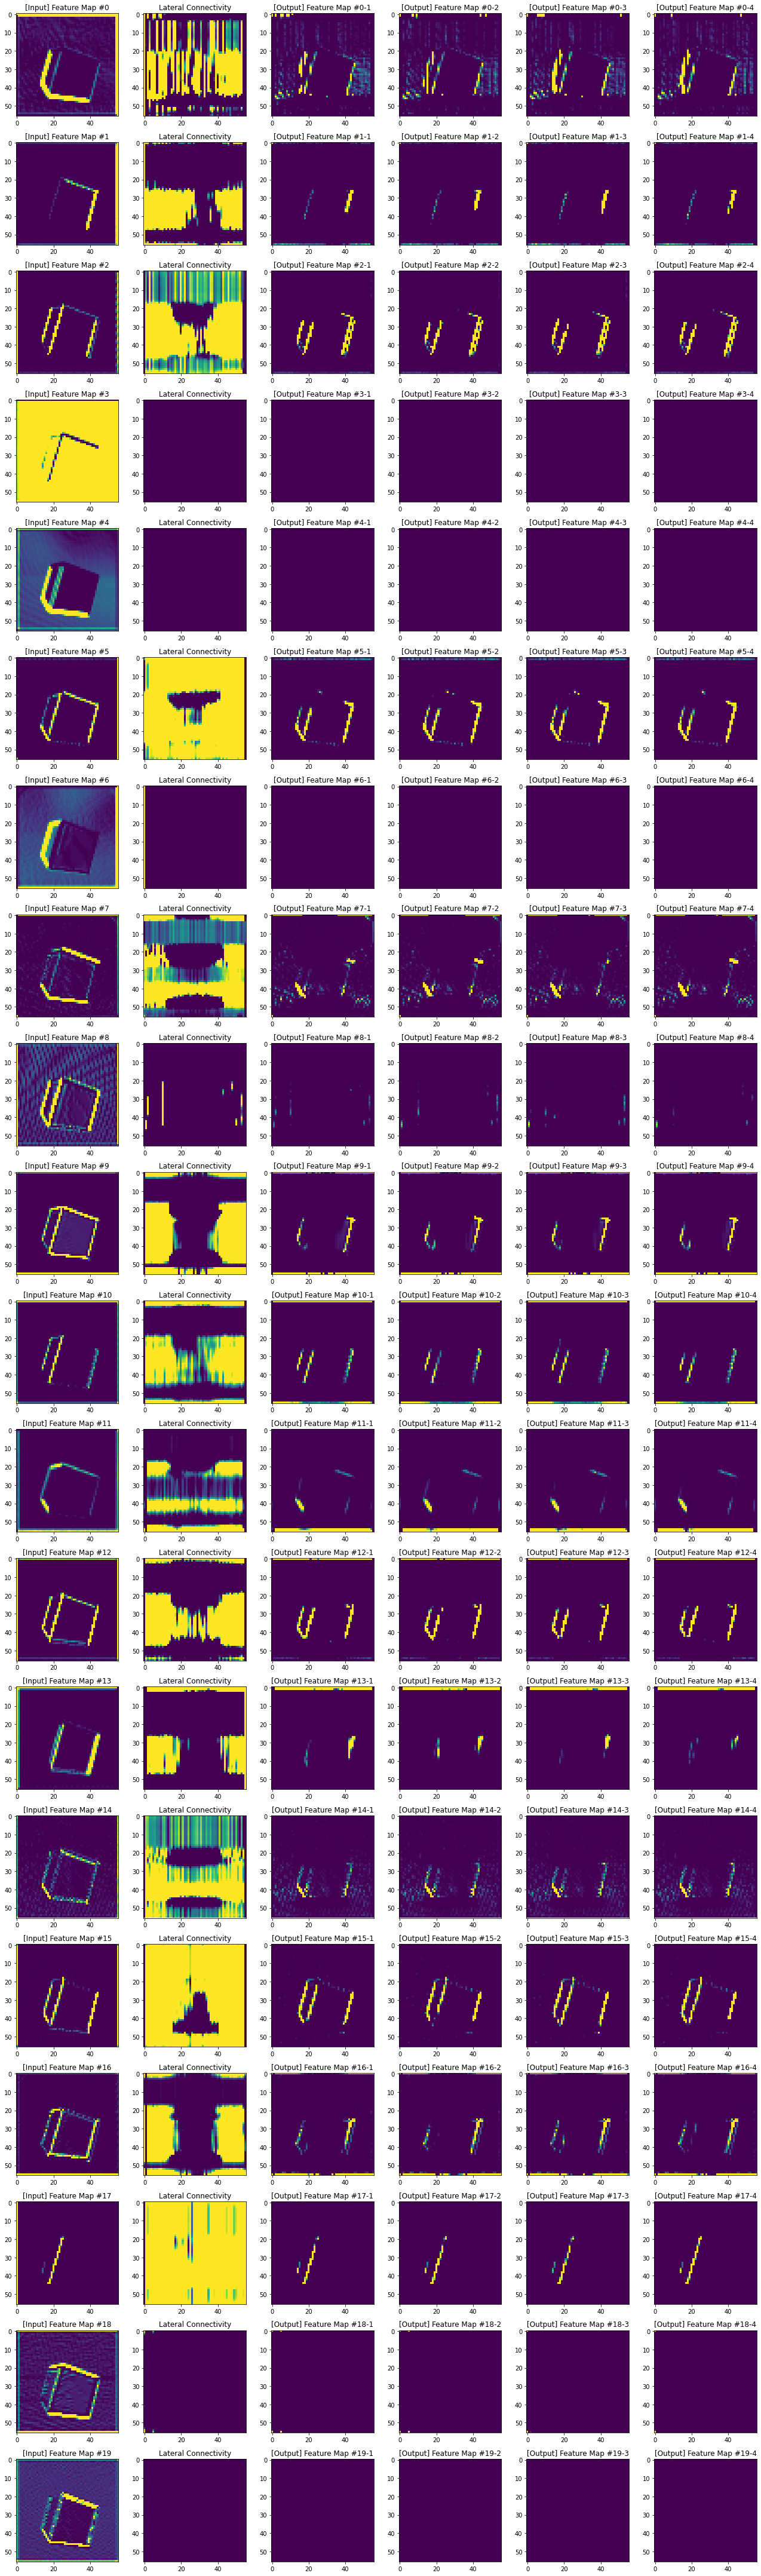

In [51]:
num_fm = 20
plot_size = 3

#feature_map_idx = np.sort(np.random.choice(model.O.shape[-3], num_fm, replace=False))
feature_map_idx = np.arange(num_fm)

fig, axs = plt.subplots(num_fm, 2 + model.num_output_repetitions, figsize=(plot_size*(2 + model.num_output_repetitions), plot_size*num_fm))
for i, fm_i in enumerate(feature_map_idx):
    axs[i][0].imshow(model.C[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][0].set_title(f"[Input] Feature Map #{fm_i}")
    
    axs[i][1].imshow(model.L[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][1].set_title(f"Lateral Connectivity")
    
    for n in range(model.num_output_repetitions):
        axs[i][2+n].imshow(model.O[n, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
        axs[i][2+n].set_title(f"[Output] Feature Map #{fm_i}-{n+1}")
    
plt.tight_layout()
